## Flight Price Prediction

In [1]:
from IPython.display import Image
Image(url= "https://i1.wp.com/thetechhacker.com/wp-content/uploads/2014/10/Top-Best-Airfare-Price-Predictor-Sites-and-Apps-To-Your-Journey.jpg?w=1000&ssl=1")

## Introduction

### Flight ticket prices can be something hard to guess, today we might see a price, check out the price of the same flight tomorrow, it will be a different story. We might have often heard travellers saying that flight ticket prices are so unpredictable. Here i will be provided with prices of flight tickets for various airlines between the months of March and June of 2019 and between various cities.

### Airline: The name of the airline.

### Date_of_Journey: The date of the journey

### Source: The source from which the service begins.

### Destination: The destination where the service ends.

### Route: The route taken by the flight to reach the destination.

### Dep_Time: The time when the journey starts from the source.

### Arrival_Time: Time of arrival at the destination.

### Duration: Total duration of the flight.

### Total_Stops: Total stops between the source and destination.

### Additional_Info: Additional information about the flight

### Price: The price of the ticket.

## Libraries

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import zscore

# preprocession, normalizing
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler

# for multicollinearity
from statsmodels.stats.outliers_influence import variance_inflation_factor

#n for models
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import AdaBoostRegressor
from sklearn.linear_model import Lasso, LassoCV
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score

import warnings
warnings.filterwarnings('ignore')
% matplotlib inline

UsageError: Line magic function `%` not found.


In [2]:
# I have import important libraries for this project in one go so that it will save time.

## Dataset

In [2]:
df = pd.read_excel('Data_Train.xlsx')
df.head()

,Airline,Date_of_Journey,Source,Destination,Route,Dep_Time,Arrival_Time,Duration,Total_Stops,Additional_Info,Price
0,IndiGo,24/03/2019,Banglore,New Delhi,BLR → DEL,22:20,01:10 22 Mar,2h 50m,non-stop,No info,3897
1,Air India,1/05/2019,Kolkata,Banglore,CCU → IXR → BBI → BLR,05:50,13:15,7h 25m,2 stops,No info,7662
2,Jet Airways,9/06/2019,Delhi,Cochin,DEL → LKO → BOM → COK,09:25,04:25 10 Jun,19h,2 stops,No info,13882
3,IndiGo,12/05/2019,Kolkata,Banglore,CCU → NAG → BLR,18:05,23:30,5h 25m,1 stop,No info,6218
4,IndiGo,01/03/2019,Banglore,New Delhi,BLR → NAG → DEL,16:50,21:35,4h 45m,1 stop,No info,13302


In [3]:
# From the dataset i can say that there are few columns in integer and few are in strings.
# All the columns have vital information so i will not be dropping any columns from the dataset except one column.

## EDA - Exploratory Data Analysis

In [3]:
df.shape

(10683, 11)

In [4]:
# There are 10683 rows and 11 columns in the dataset.

In [4]:
pd.set_option('display.max_rows',None)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10683 entries, 0 to 10682
Data columns (total 11 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   Airline          10683 non-null  object
 1   Date_of_Journey  10683 non-null  object
 2   Source           10683 non-null  object
 3   Destination      10683 non-null  object
 4   Route            10682 non-null  object
 5   Dep_Time         10683 non-null  object
 6   Arrival_Time     10683 non-null  object
 7   Duration         10683 non-null  object
 8   Total_Stops      10682 non-null  object
 9   Additional_Info  10683 non-null  object
 10  Price            10683 non-null  int64 
dtypes: int64(1), object(10)
memory usage: 918.2+ KB


In [5]:
# It is a mixed dataset as 10 columns are object type and 1 columns are integers type.
# There is 1 missing values in 2 columns which i will fix soon.

In [5]:
df.drop_duplicates(inplace = True)

In [6]:
df.shape

(10463, 11)

In [6]:
# There are few duplicates value in the datset.
# Now there are 10463 rows and 11 columns in the dataset.

In [7]:
df.nunique()

Airline              12
Date_of_Journey      44
Source                5
Destination           6
Route               128
Dep_Time            222
Arrival_Time       1343
Duration            368
Total_Stops           5
Additional_Info      10
Price              1870
dtype: int64

In [7]:
# There are few columns which are categorical in nature and few columns are continous in nature.

### Date_of_Journey

In [8]:
df["Journey_day"] = pd.to_datetime(df.Date_of_Journey, format="%d/%m/%Y").dt.day
df["Journey_month"] = pd.to_datetime(df["Date_of_Journey"], format = "%d/%m/%Y").dt.month

df.drop(["Date_of_Journey"], axis = 1, inplace = True)

In [8]:
# I have converted Date_of_Journey column into integers.
# Since i have converted Date_of_Journey column into integers, Now we can drop as it is of no use.

### Departure time 

In [9]:
df["Dep_hour"] = pd.to_datetime(df["Dep_Time"]).dt.hour

df["Dep_min"] = pd.to_datetime(df["Dep_Time"]).dt.minute

df.drop(["Dep_Time"], axis = 1, inplace = True)

In [9]:
# Departure time is when a plane leaves the gate. 
# Similar to Date_of_Journey we can extract values from Dep_Time
# I have extracted depature hour and departure minute from Departure time column.
# # Now i can drop Dep_Time as it is of no use

### Arrival_Time

In [10]:
df["Arrival_hour"] = pd.to_datetime(df.Arrival_Time).dt.hour

df["Arrival_min"] = pd.to_datetime(df.Arrival_Time).dt.minute

df.drop(["Arrival_Time"], axis = 1, inplace = True)

In [10]:
# Arrival time is when the plane pulls up to the gate.
# Similar to Date_of_Journey we can extract values from Arrival_Time
# I have extracted Arrival hour and Arrival minute from Departure time column.
# Now i can drop Arrival_Time as it is of no use

## Duration

In [11]:
duration = list(df["Duration"])

for i in range(len(duration)):
    if len(duration[i].split()) != 2:    
        if "h" in duration[i]:
            duration[i] = duration[i].strip() + " 0m"   
        else:
            duration[i] = "0h " + duration[i]           

duration_hours = []
duration_mins = []
for i in range(len(duration)):
    duration_hours.append(int(duration[i].split(sep = "h")[0]))    
    duration_mins.append(int(duration[i].split(sep = "m")[0].split()[-1]))   

In [12]:
df["Duration_hours"] = duration_hours
df["Duration_mins"] = duration_mins

# dropping duration columns
df.drop(["Duration"], axis = 1, inplace = True)

In [12]:
# I have extract hours from duration.
# I have extract minutes from duration.
# I will be dropping duration columns now.

In [14]:
df.head()

,Airline,Source,Destination,Route,Total_Stops,Additional_Info,Price,Journey_day,Journey_month,Dep_hour,Dep_min,Arrival_hour,Arrival_min,Duration_hours,Duration_mins
0,IndiGo,Banglore,New Delhi,BLR → DEL,non-stop,No info,3897,24,3,22,20,1,10,2,50
1,Air India,Kolkata,Banglore,CCU → IXR → BBI → BLR,2 stops,No info,7662,1,5,5,50,13,15,7,25
2,Jet Airways,Delhi,Cochin,DEL → LKO → BOM → COK,2 stops,No info,13882,9,6,9,25,4,25,19,0
3,IndiGo,Kolkata,Banglore,CCU → NAG → BLR,1 stop,No info,6218,12,5,18,5,23,30,5,25
4,IndiGo,Banglore,New Delhi,BLR → NAG → DEL,1 stop,No info,13302,1,3,16,50,21,35,4,45


In [13]:
# Now the number of columns increased.
# Now i have  columns in the dataset.

## Handling Categorical Data

## Cat Plot

#### Airline

In [15]:
df["Airline"].value_counts()

Jet Airways                          3700
IndiGo                               2043
Air India                            1695
Multiple carriers                    1196
SpiceJet                              815
Vistara                               478
Air Asia                              319
GoAir                                 194
Multiple carriers Premium economy      13
Jet Airways Business                    6
Vistara Premium economy                 3
Trujet                                  1
Name: Airline, dtype: int64

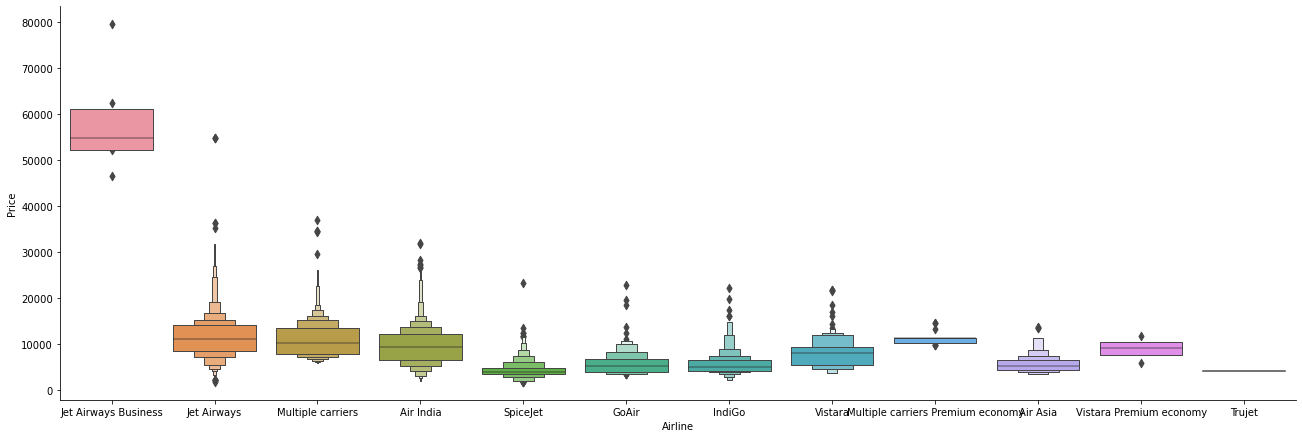

In [16]:
# Airline vs Price
sns.catplot(y = "Price", x = "Airline", data = df.sort_values("Price", ascending = False), kind="boxen", height = 6, aspect = 3)
plt.show()

In [14]:
# Jet Airways Business flight price is high as compared to other flight service.

### Dep_hour

In [17]:
df["Dep_hour"].value_counts()

9     887
7     863
8     694
17    689
6     675
20    649
5     582
11    579
19    544
10    527
14    505
21    489
16    461
18    441
13    411
22    373
15    319
2     194
12    178
4     169
23    133
0      40
1      37
3      24
Name: Dep_hour, dtype: int64

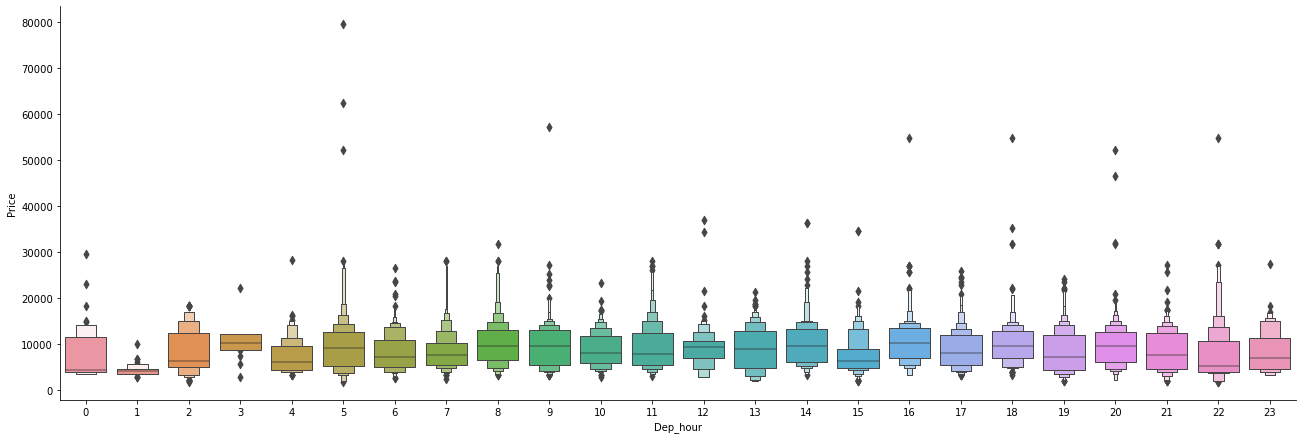

In [18]:
# Airline vs Price
sns.catplot(y = "Price", x = "Dep_hour", data = df.sort_values("Price", ascending = False), kind="boxen", height = 6, aspect = 3)
plt.show()

In [15]:
# Departure hour doesn't affect flight price.

### Dep_min

In [19]:
df["Dep_min"].value_counts()

0     2039
30    1173
55    1052
10     870
45     858
5      740
15     684
25     679
20     664
35     645
50     586
40     473
Name: Dep_min, dtype: int64

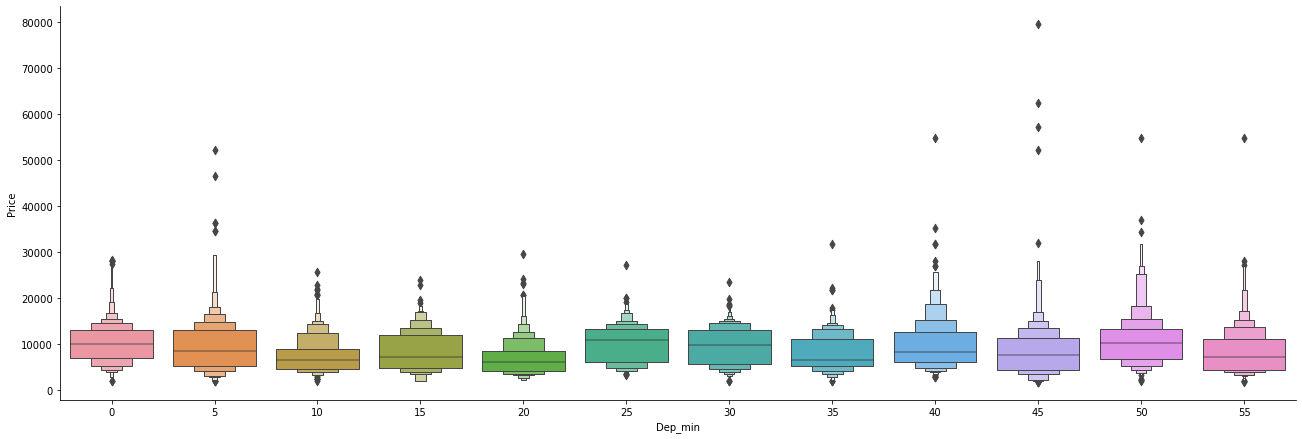

In [20]:
# Airline vs Price
sns.catplot(y = "Price", x = "Dep_min", data = df.sort_values("Price", ascending = False), kind="boxen", height = 6, aspect = 3)
plt.show()

In [16]:
# Departure min doesn't affect flight price.

## Bar Plot

#### Source

In [21]:
df["Source"].value_counts()

Delhi       4346
Kolkata     2860
Banglore    2179
Mumbai       697
Chennai      381
Name: Source, dtype: int64

<AxesSubplot:xlabel='Source', ylabel='Price'>

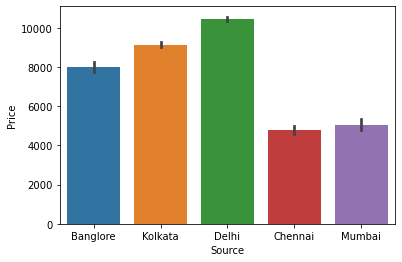

In [22]:
sns.barplot(df['Source'],df['Price'])

In [17]:
# From delhi the flight price is high as compared to other cities.

### Arrival_hour

In [23]:
df["Arrival_hour"].value_counts()

19    1554
12     861
4      761
21     701
22     646
1      525
18     509
9      490
23     481
10     474
8      468
7      414
20     377
16     370
0      322
13     303
11     297
14     294
17     191
15     182
2       79
5       66
6       51
3       47
Name: Arrival_hour, dtype: int64

<AxesSubplot:xlabel='Arrival_hour', ylabel='Price'>

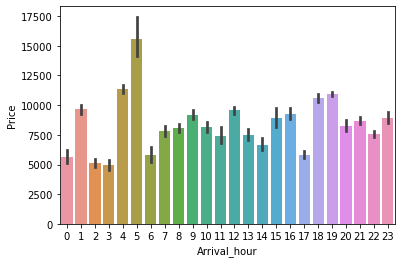

In [24]:
sns.barplot(df['Arrival_hour'],df['Price'])

In [18]:
# Those flight have 5 hours journey there price is high.

### Arrival_min

In [25]:
df["Arrival_min"].value_counts()

0     1417
15    1245
25    1225
35    1070
20     894
30     831
50     744
45     689
5      659
40     626
10     576
55     487
Name: Arrival_min, dtype: int64

<AxesSubplot:xlabel='Arrival_min', ylabel='Price'>

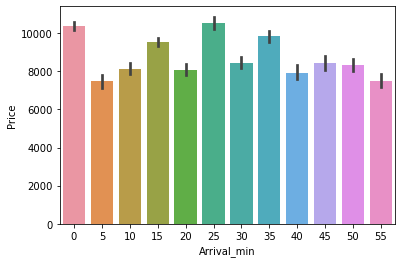

In [26]:
sns.barplot(df['Arrival_min'],df['Price'])

In [19]:
# Those flight have 25 mins journey there price is high.

## Strip Plot

#### Destination

In [27]:
df["Destination"].value_counts()

Cochin       4346
Banglore     2860
Delhi        1265
New Delhi     914
Hyderabad     697
Kolkata       381
Name: Destination, dtype: int64

<AxesSubplot:xlabel='Destination', ylabel='Price'>

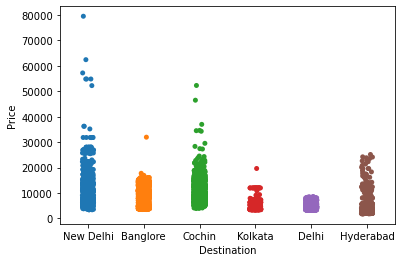

In [28]:
sns.stripplot(df['Destination'],df['Price'])

In [20]:
# Those flight have New Delhi as a destination journey there price is high.

### Arrival_min

In [29]:
df["Arrival_min"].value_counts()

0     1417
15    1245
25    1225
35    1070
20     894
30     831
50     744
45     689
5      659
40     626
10     576
55     487
Name: Arrival_min, dtype: int64

<AxesSubplot:xlabel='Arrival_min', ylabel='Price'>

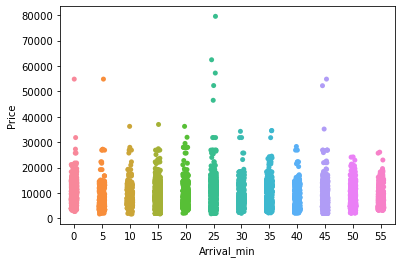

In [30]:
sns.stripplot(df['Arrival_min'],df['Price'])

In [21]:
# Those flight have 25 mins journey there price is high.

## Dropping columns

In [31]:
df.drop(["Route", "Additional_Info"], axis = 1, inplace = True)

#### Total_Stops

In [32]:
df["Total_Stops"].value_counts()

1 stop      5625
non-stop    3475
2 stops     1318
3 stops       43
4 stops        1
Name: Total_Stops, dtype: int64

<AxesSubplot:xlabel='Total_Stops', ylabel='Price'>

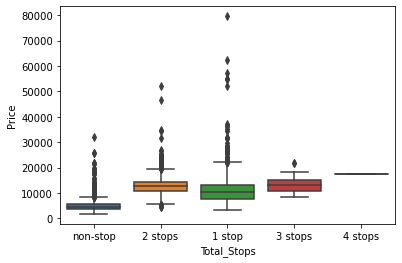

In [33]:
sns.boxplot(df['Total_Stops'],df['Price'])

In [22]:
# Those flight have 1 stop journey there price is high.

### Additional_Info

In [34]:
df["Journey_day"].value_counts()

9     1375
6     1269
27    1092
21    1085
1     1058
24    1022
15     967
12     946
3      835
18     814
Name: Journey_day, dtype: int64

<AxesSubplot:xlabel='Journey_day', ylabel='Price'>

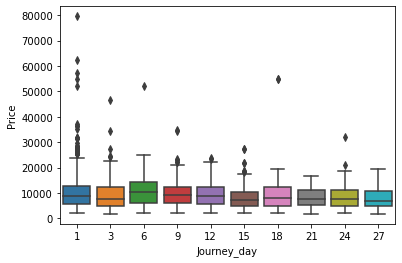

In [35]:
sns.boxplot(df['Journey_day'],df['Price'])

In [23]:
# Those flight have 1 day journey there price is high.

### Journey_month

In [36]:
df["Journey_month"].value_counts()

5    3396
6    3311
3    2678
4    1078
Name: Journey_month, dtype: int64

<AxesSubplot:xlabel='Journey_month', ylabel='Price'>

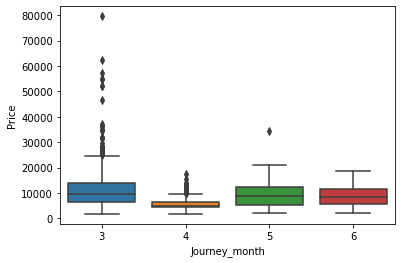

In [37]:
sns.boxplot(df['Journey_month'],df['Price'])

In [24]:
# Those people who are travelling for around 3 months are paying high price for flight.

## Label Encoder

In [40]:
# As this is case of Ordinal Categorical type we perform LabelEncoder
# Here Values are assigned with corresponding keys
df.replace({"non-stop": 0, "1 stop": 1, "2 stops": 2, "3 stops": 3, "4 stops": 4}, inplace = True)
df.replace({"Cochin": 0, "Banglore": 1, "Delhi": 2, "New Delhi": 3, "Hyderabad": 4,"Kolkata":5}, inplace = True)
df.replace({"Delhi": 0, "Kolkata": 1, "Banglore": 2, "Mumbai": 3, "Chennai": 4}, inplace = True)
df.replace({"Jet Airways": 0, "IndiGo": 1, "Air India": 2, "Multiple carriers": 3, "SpiceJet": 4,"Vistara":5,"Air Asia":6,"GoAir":7,"Multiple carriers Premium economy":8,"Jet Airways Business":9,"Vistara Premium economy":10,"Trujet":11}, inplace = True)

In [25]:
# I have used label encoder to convert the strings values into intergers.
# It will help me in model building.

## Pairplot

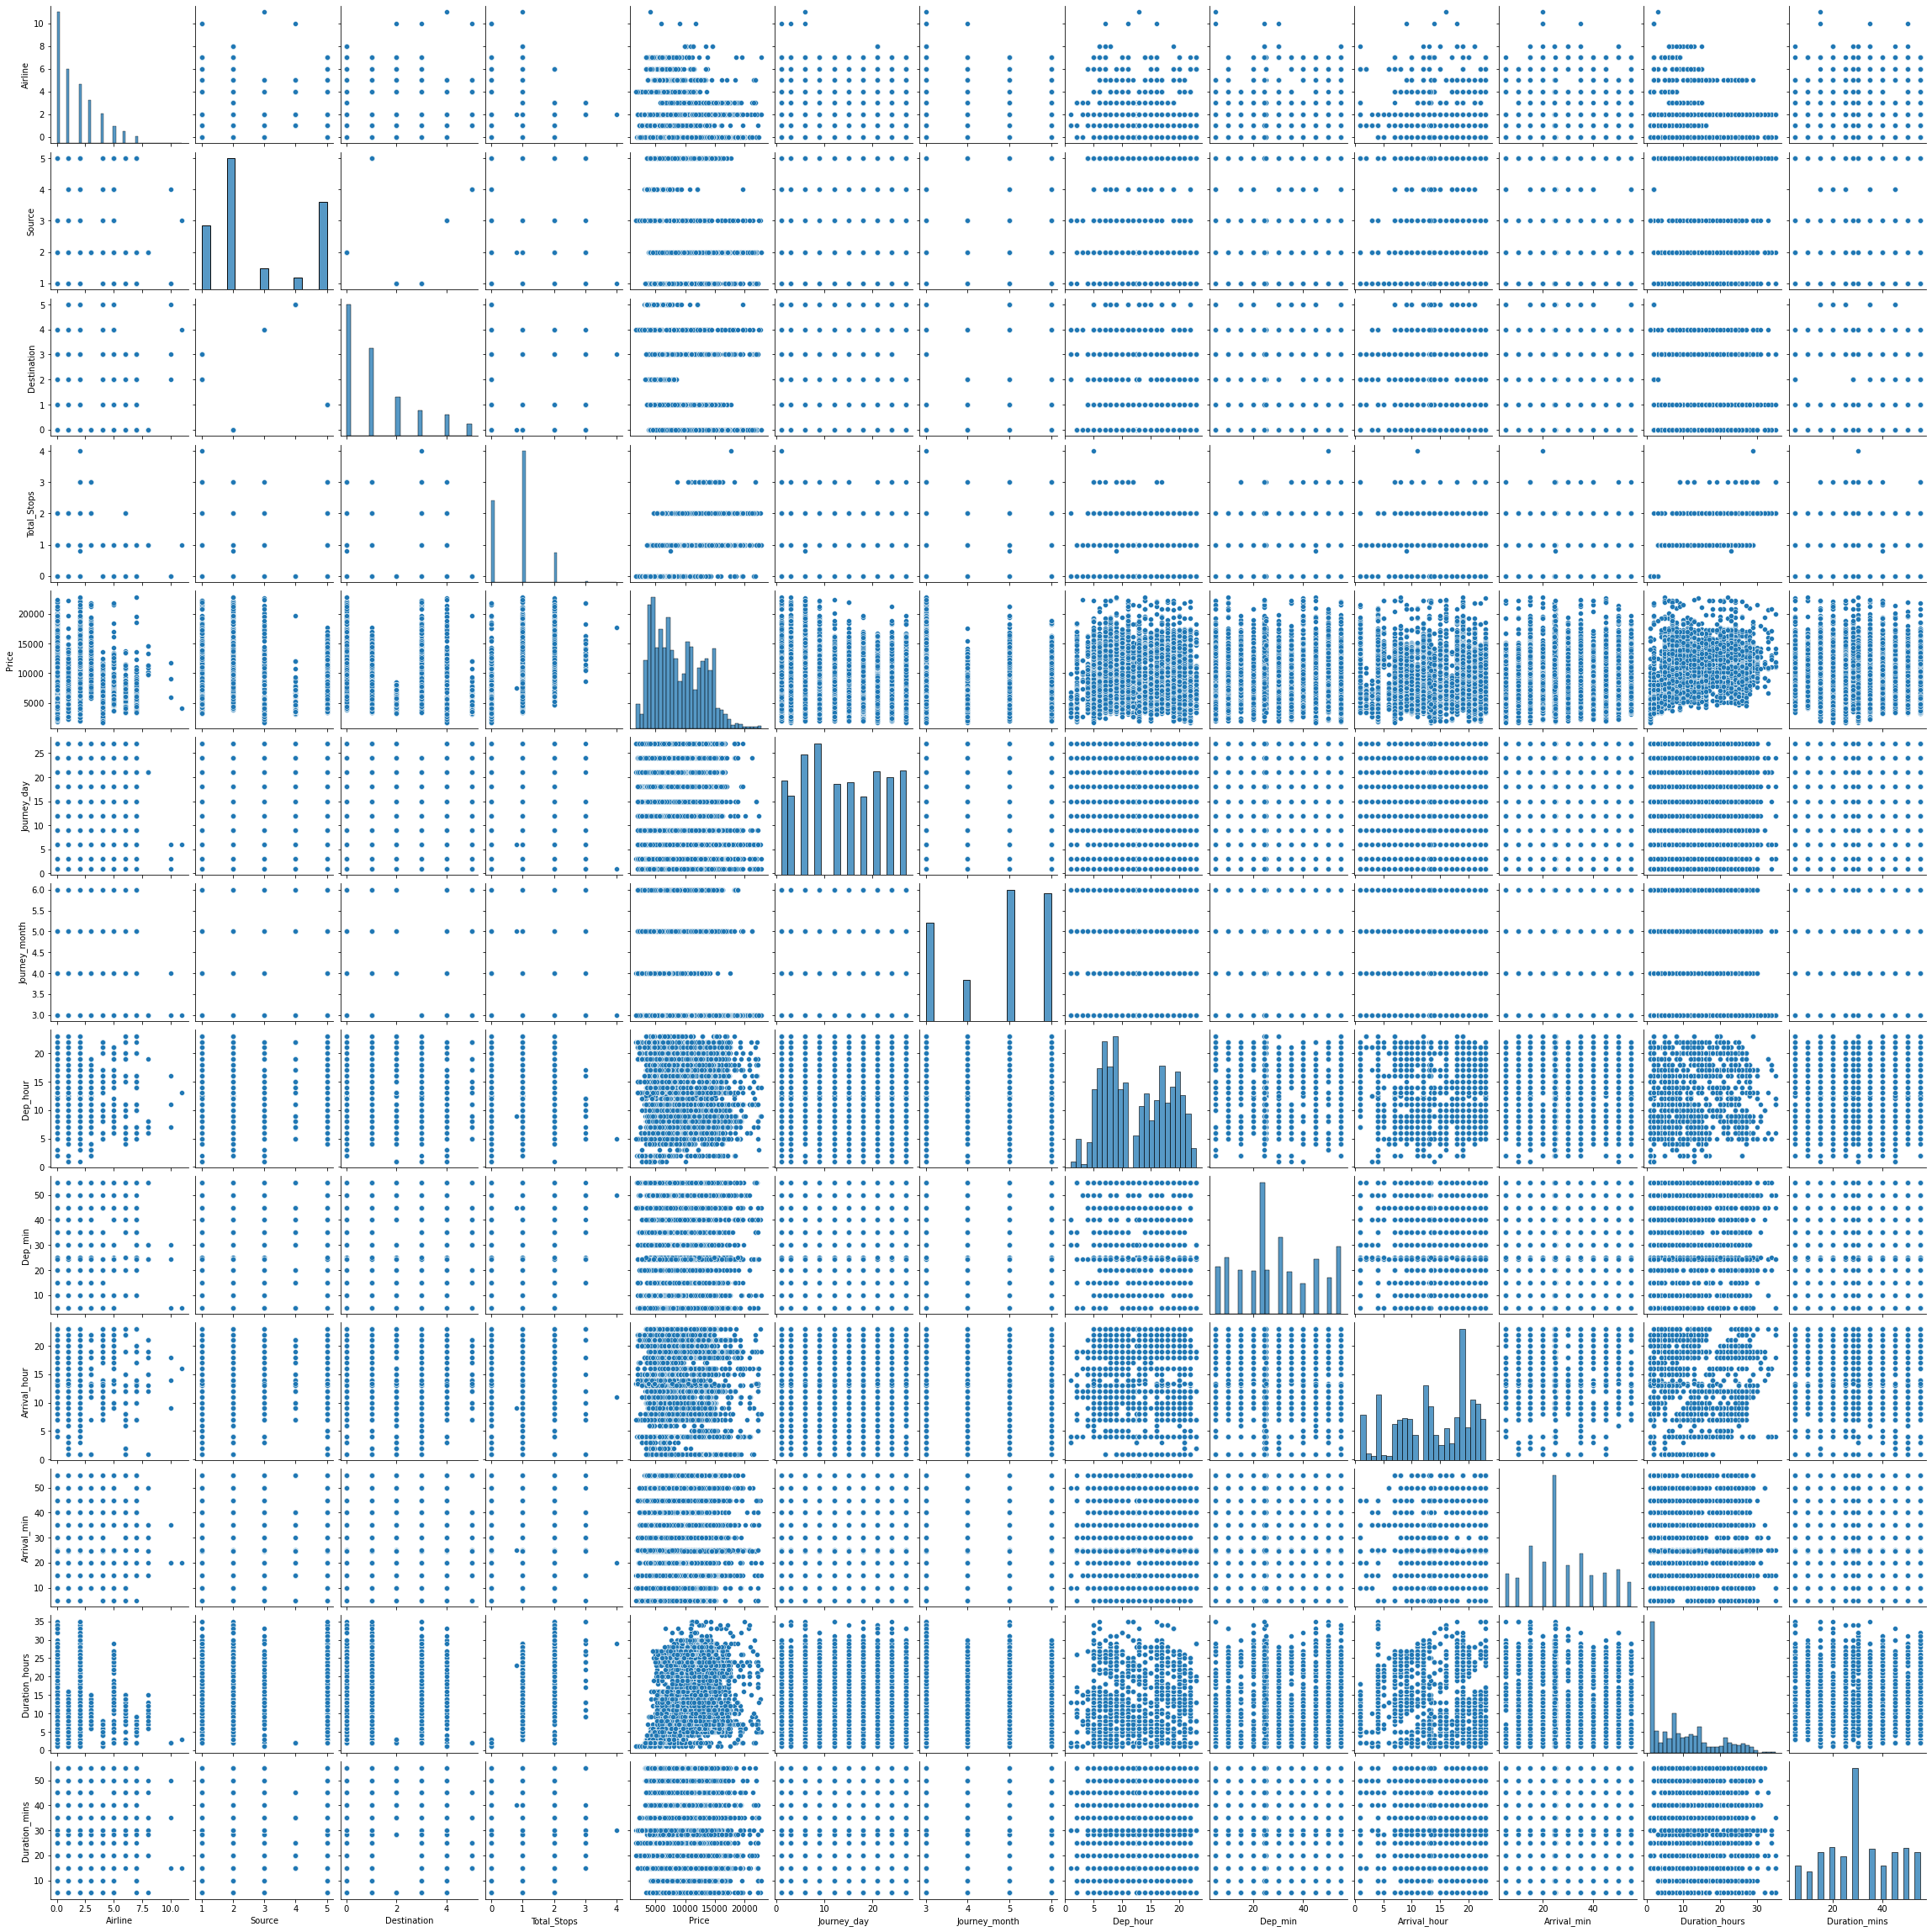

In [105]:
sns.pairplot(df)

In [26]:
# The above pair plot gives us the clear idea that target variable 'Price' are positively corelated with few feature.
# Only few columns are not correlated.

## Filling the missing values

In [42]:
# filling the missing values of continious columns
df['Total_Stops'].fillna(df['Total_Stops'].mean(),inplace=True)

In [27]:
# There is missing value in Total_Stops columns which i fill it with mean.

In [43]:
df.describe()

,Airline,Source,Destination,Total_Stops,Price,Journey_day,Journey_month,Dep_hour,Dep_min,Arrival_hour,Arrival_min,Duration_hours,Duration_mins
count,10463.000000,10463.000000,10463.000000,10463.000000,10463.000000,10463.000000,10463.00000,10463.000000,10463.000000,10463.000000,10463.000000,10463.000000,10463.000000
mean,1.733920,2.751219,1.225748,0.802332,9026.642454,13.462487,4.70152,12.478161,24.406958,13.387269,24.719966,10.027430,28.211316
std,1.851111,1.522012,1.420243,0.660577,4624.653227,8.467403,1.16375,5.727055,18.815897,6.855353,16.569658,8.378582,16.878771
min,0.000000,1.000000,0.000000,0.000000,1759.000000,1.000000,3.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,2.000000,0.000000,0.000000,5224.000000,6.000000,3.00000,8.000000,5.000000,8.000000,10.000000,2.000000,15.000000
50%,1.000000,2.000000,1.000000,1.000000,8266.000000,12.000000,5.00000,11.000000,25.000000,14.000000,25.000000,8.000000,30.000000
75%,3.000000,5.000000,2.000000,1.000000,12343.500000,21.000000,6.00000,18.000000,40.000000,19.000000,35.000000,15.000000,45.000000
max,11.000000,5.000000,5.000000,4.000000,79512.000000,27.000000,6.00000,23.000000,55.000000,23.000000,55.000000,47.000000,55.000000


In [28]:
# Total number of counts in each columns is matching as there is no missing values.
# The difference between the mean and 50% is not much.
# There are outlires in the dataset which i will remove it soon.

## Distribution Plot

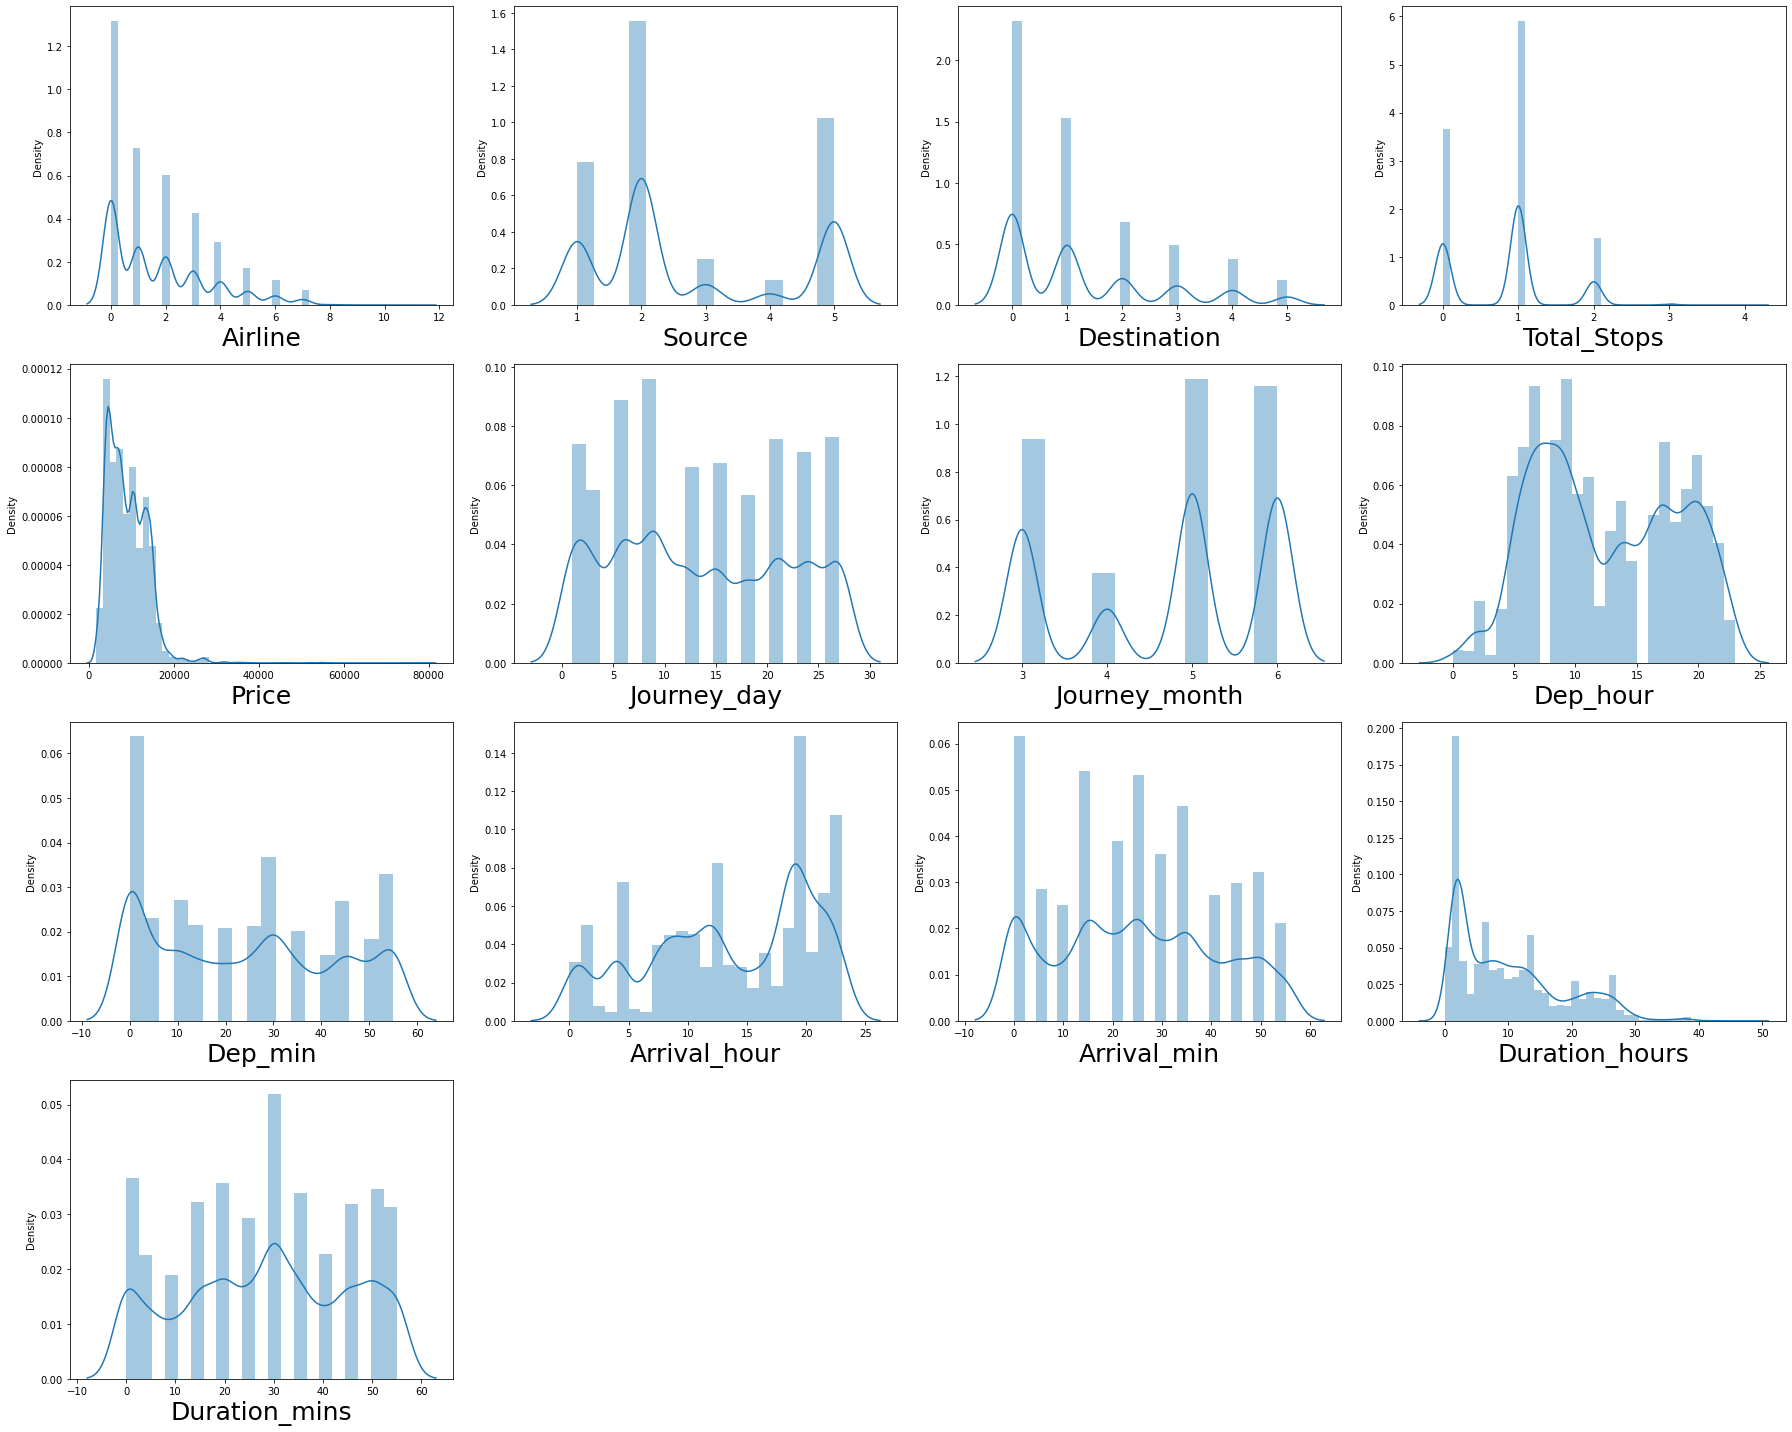

In [44]:
# using the the distribution plot 

plt.figure(figsize=(25,20), facecolor='white')
plotnumber = 1

for column in df:
    if plotnumber<=13:
        ax=plt.subplot(4,4,plotnumber)
        sns.distplot(df[column])
        plt.xlabel(column,fontsize=25)
    plotnumber+=1
plt.tight_layout() 

In [29]:
# There are skewness in the dataset which i will remove soon.
# There are few zero values as well that also need to be taken care.

## Replacing all the zero values from different columns

In [45]:
# Replacing continous columns with mean
df['Dep_hour']=df['Dep_hour'].replace(0,df['Dep_hour'].mean())
df['Dep_min']=df['Dep_min'].replace(0,df['Dep_min'].mean())
df['Arrival_hour']=df['Arrival_hour'].replace(0,df['Arrival_hour'].mean())
df['Arrival_min']=df['Arrival_min'].replace(0,df['Arrival_min'].mean())
df['Duration_hours']=df['Duration_hours'].replace(0,df['Duration_hours'].mean())
df['Duration_mins']=df['Duration_mins'].replace(0,df['Duration_mins'].mean())

In [30]:
# There are few zero values that got replaced with the help of mean.

## Box Plot

Airline               AxesSubplot(0.125,0.71587;0.168478x0.16413)
Source             AxesSubplot(0.327174,0.71587;0.168478x0.16413)
Destination        AxesSubplot(0.529348,0.71587;0.168478x0.16413)
Total_Stops        AxesSubplot(0.731522,0.71587;0.168478x0.16413)
Price                AxesSubplot(0.125,0.518913;0.168478x0.16413)
Journey_day       AxesSubplot(0.327174,0.518913;0.168478x0.16413)
Journey_month     AxesSubplot(0.529348,0.518913;0.168478x0.16413)
Dep_hour          AxesSubplot(0.731522,0.518913;0.168478x0.16413)
Dep_min              AxesSubplot(0.125,0.321957;0.168478x0.16413)
Arrival_hour      AxesSubplot(0.327174,0.321957;0.168478x0.16413)
Arrival_min       AxesSubplot(0.529348,0.321957;0.168478x0.16413)
Duration_hours    AxesSubplot(0.731522,0.321957;0.168478x0.16413)
Duration_mins           AxesSubplot(0.125,0.125;0.168478x0.16413)
dtype: object

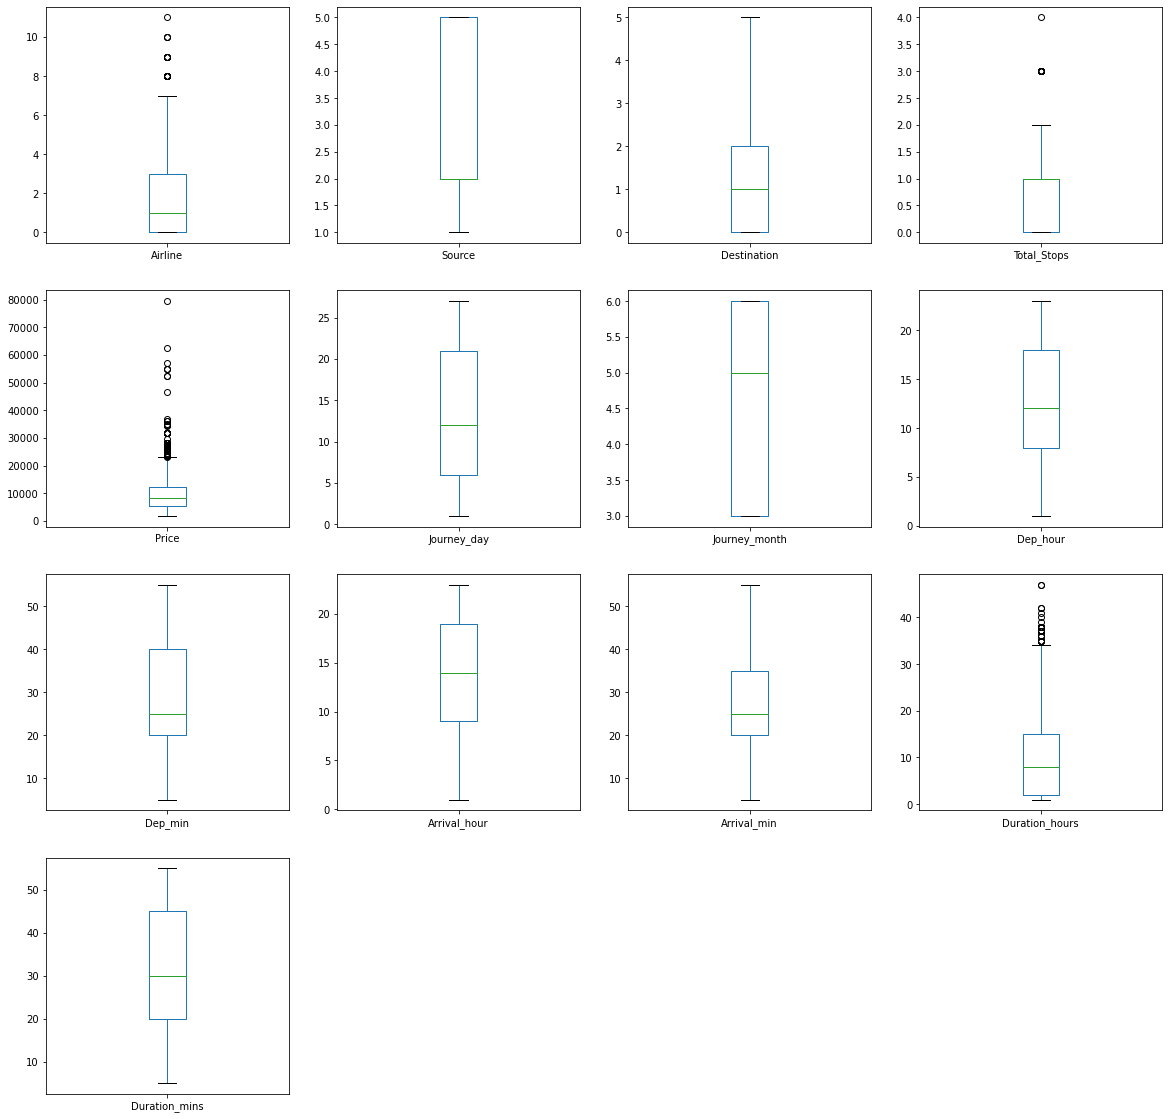

In [46]:
df.plot(kind='box',subplots=True,layout=(4,4),figsize=(20,20))

In [31]:
# There are outliers in the dataset which i will fix it with the help of Z score.

## Z score

In [47]:
z_score = zscore(df[['Duration_hours','Price']])
abs_z_score = np.abs(z_score)

filtering_entry = (abs_z_score < 3).all(axis = 1)
df = df[filtering_entry]
df.describe()

,Airline,Source,Destination,Total_Stops,Price,Journey_day,Journey_month,Dep_hour,Dep_min,Arrival_hour,Arrival_min,Duration_hours,Duration_mins
count,10308.000000,10308.000000,10308.000000,10308.000000,10308.000000,10308.000000,10308.000000,10308.000000,10308.000000,10308.000000,10308.000000,10308.000000,10308.000000
mean,1.740784,2.768238,1.218665,0.791114,8811.150757,13.560924,4.722352,12.562201,29.097050,13.776968,28.099495,9.844783,30.994955
std,1.849519,1.524208,1.417131,0.654207,4061.260145,8.430454,1.155234,5.663605,14.637875,6.431762,13.437356,8.133227,14.193786
min,0.000000,1.000000,0.000000,0.000000,1759.000000,1.000000,3.000000,1.000000,5.000000,1.000000,5.000000,1.000000,5.000000
25%,0.000000,2.000000,0.000000,0.000000,5198.000000,6.000000,4.000000,8.000000,20.000000,9.000000,20.000000,2.000000,20.000000
50%,1.000000,2.000000,1.000000,1.000000,8073.000000,12.000000,5.000000,12.000000,25.000000,14.000000,25.000000,8.000000,30.000000
75%,3.000000,5.000000,2.000000,1.000000,12199.000000,21.000000,6.000000,18.000000,40.000000,19.000000,35.000000,15.000000,45.000000
max,11.000000,5.000000,5.000000,4.000000,22798.000000,27.000000,6.000000,23.000000,55.000000,23.000000,55.000000,35.000000,55.000000


In [48]:
df.shape

(10308, 13)

In [32]:
# I have used the Z Score to remove the outliers from the datset.
# Now there are 10308 rows and 13 columns in the dataset.

## Heatmap

[]

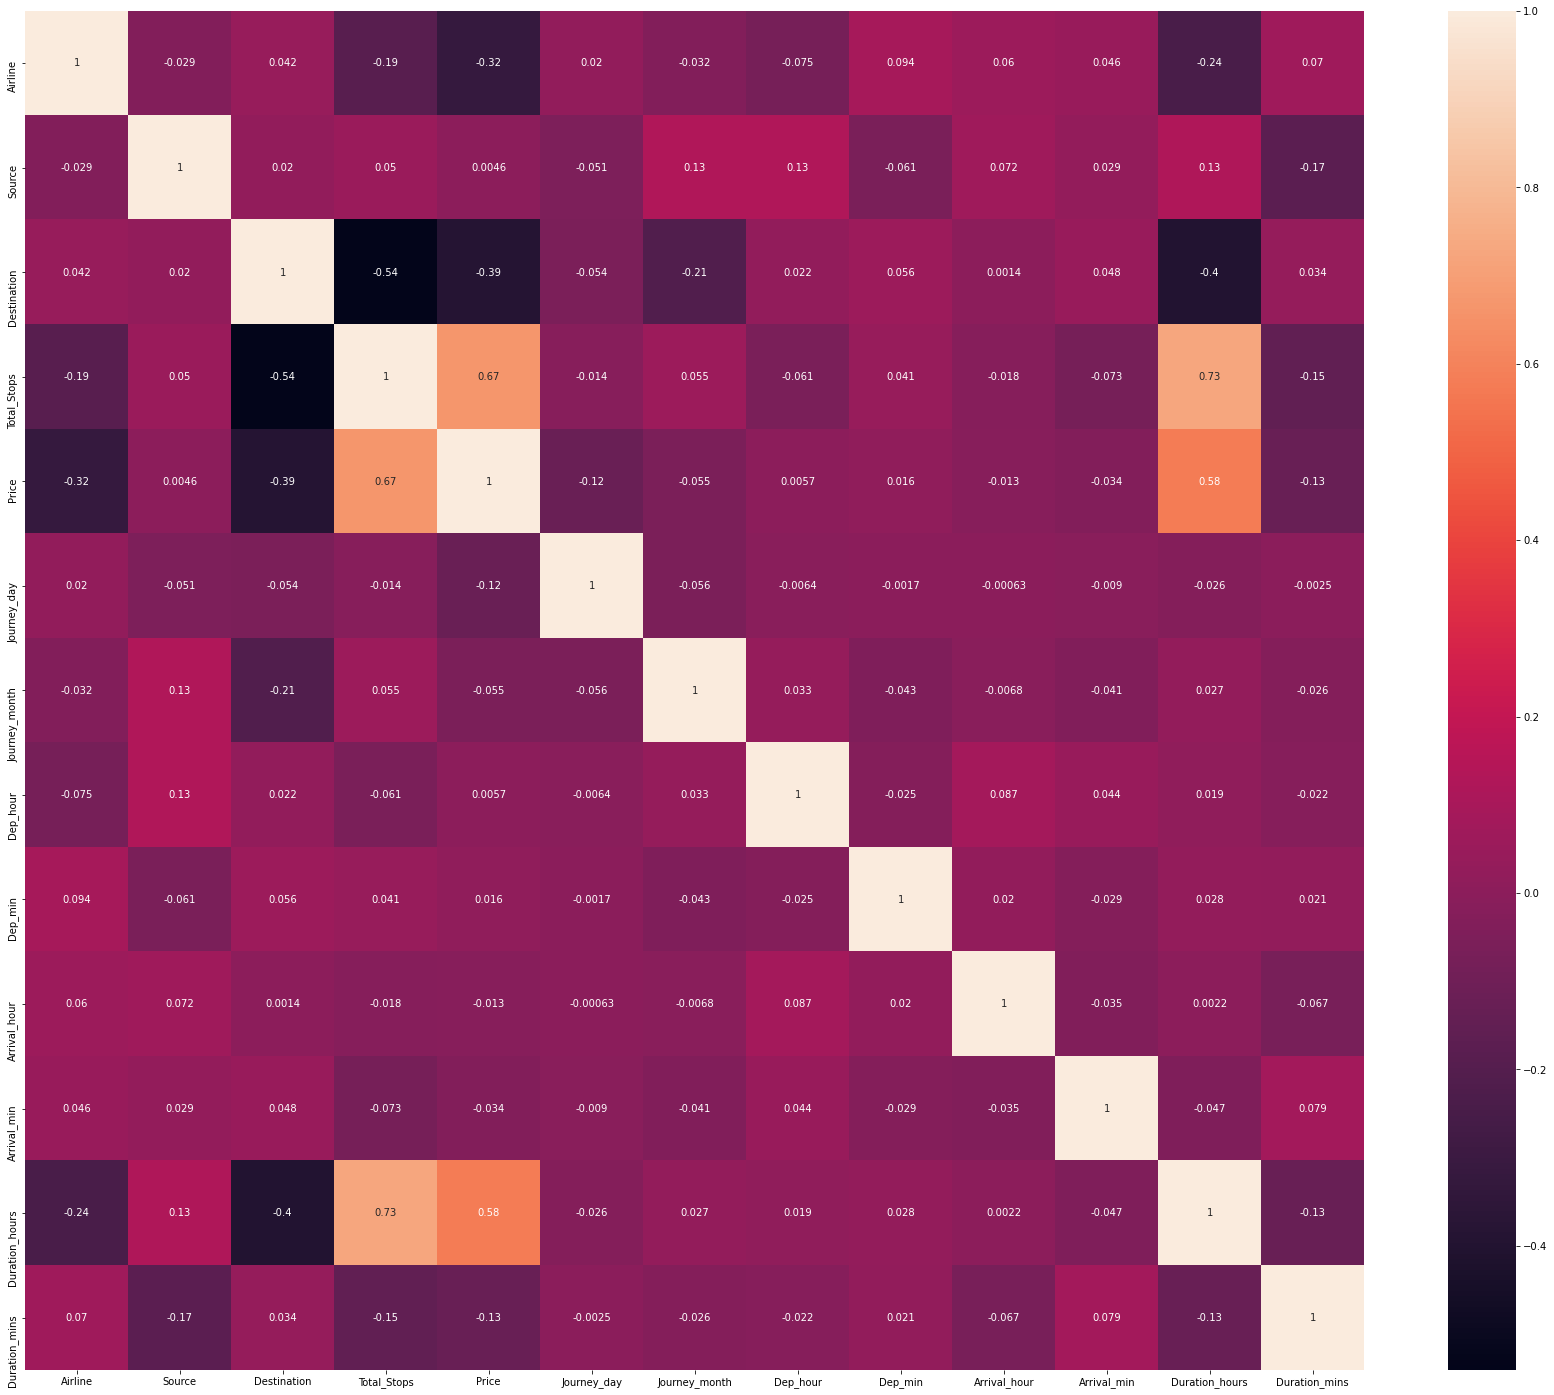

In [53]:
#checking the co-relation of all column to each other
df_cor = df.corr()
plt.figure(figsize=(30,25))
sns.heatmap(df_cor,annot=True)
plt.plot()

In [33]:
# Total stops and price is positively correlated with each other.
# Duration hour and price is positively correlated with each other.
# Duration and Total stops is positively correlated with each other.
# Total stops and Destination are negatively correlated to each other.
# Destination and price services are negatively correlated to each other.

## Machine Learning

In [49]:
# dividing features and label

x = df.drop('Price',axis=1)
y = df.Price

In [34]:
# I have divided dataset into feature and label.

## StandardScaler

In [50]:
# standard scaler

scaler = StandardScaler()
x_scaled = scaler.fit_transform(x)
x_scaled

array([[-0.40054723, -1.16015938,  1.25706213, ..., -1.34701889,
        -0.96458196,  1.33903437],
       [ 0.14016006,  1.46428192, -0.15430879, ..., -0.97490383,
        -0.34979   , -0.42238521],
       [-0.94125451, -0.50404905, -0.85999426, ..., -0.23067373,
         1.12571072, -0.19612621],
       ...,
       [-0.94125451, -1.16015938,  0.55137667, ..., -0.60278878,
        -0.84162357, -0.19612621],
       [ 1.76228191, -1.16015938,  1.25706213, ..., -1.34701889,
        -0.96458196,  0.63446653],
       [ 0.14016006, -0.50404905, -0.85999426, ..., -0.97490383,
        -0.2268316 , -0.77466913]])

In [35]:
# Standard scaler is basically scaling the date in one range so that it will be easy for Model building.

## Visualize the correlation

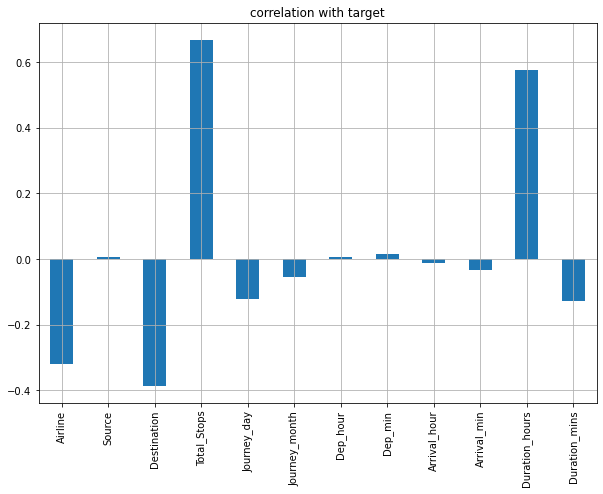

In [51]:
df.drop('Price',axis=1).corrwith(df.Price).plot(kind='bar',grid=True,figsize=(10,7),title="correlation with target")
plt.show()

In [37]:
# The above plot gives me an clear idea that few columns are positively correlated and few are negatively correlated with label.
# However i will use all the columns for model prediction.

## VIF - variance inflation factor

In [52]:
# finding variance inflation factor(vif)

vif = pd.DataFrame()
vif["vif"] = [variance_inflation_factor(x_scaled,i) for i in range (x_scaled.shape[1])]
vif["Features"] = x.columns
vif

,vif,Features
0,1.098401,Airline
1,1.099505,Source
2,1.540076,Destination
3,2.596374,Total_Stops
4,1.013425,Journey_day
5,1.087424,Journey_month
6,1.043244,Dep_hour
7,1.030624,Dep_min
8,1.022978,Arrival_hour
9,1.019383,Arrival_min


In [38]:
# VIF is used to detect the severity of multicollinearity in the ordinary least square (OLS) regression analysis.
# Multicollinearity is a phenomenon when two or more independent variables are highly intercorrelated.
# From the above stats i can say that none of the features are highly intercorrelated it means Multicollinearity doesn't exist.

## Model Building

In [54]:
x_train,x_test,y_train,y_test = train_test_split(x_scaled,y,test_size=0.25,random_state = 370)

In [39]:
# For model prediction i am dividing the dataset into 2 parts.
# One part is used for training purpose i.e 75% dataset.
# other part is used for testing purpose i.e 25% dataset.

## Linear Regression model

In [55]:
rg = LinearRegression()
rg.fit(x_train,y_train)

LinearRegression()

In [56]:
# adjusted r2 score
rg.score(x_train,y_train)

0.5211726205173783

In [57]:
rg.score(x_test,y_test)

0.5353513551149165

In [58]:
y_pred = rg.predict(x_test)
y_pred

array([ 6562.85933378, 10259.8302461 ,  9353.95588065, ...,
        9758.89322486, 10337.02967641,  4502.07355808])

### Scatter plot of Linear Regression

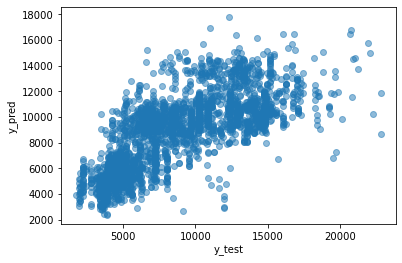

In [59]:
plt.scatter(y_test, y_pred, alpha = 0.5)
plt.xlabel("y_test")
plt.ylabel("y_pred")
plt.show()

### MSE

In [60]:
mean_squared_error(y_test,y_pred)

7750547.274777671

### RMSE

In [61]:
np.sqrt(mean_squared_error(y_test,y_pred))

2783.9804731315326

### r2 score

In [62]:
r2_score(y_test,y_pred)

0.5353513551149165

In [40]:
# Linear Regression accuracy score 53%

## Decision Tree Regressor Model

In [63]:
dt = DecisionTreeRegressor()
dt.fit(x_train,y_train)

DecisionTreeRegressor()

In [64]:
# adjusted r2 score
dt.score(x_train,y_train)

0.9629219415843084

In [65]:
dt.score(x_test,y_test)

0.7189158671793642

In [66]:
y_pred = dt.predict(x_test)
y_pred

array([ 5000.,  5883.,  8425., ...,  8937., 10577.,  3543.])

### Scatter plot of Decision Tree Regressor Model

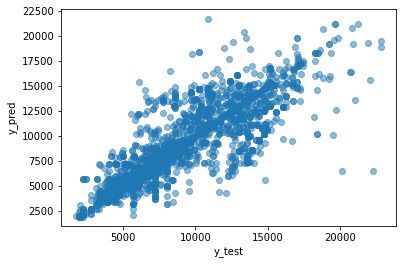

In [67]:
plt.scatter(y_test, y_pred, alpha = 0.5)
plt.xlabel("y_test")
plt.ylabel("y_pred")
plt.show()

### MSE

In [68]:
mean_squared_error(y_test,y_pred)

4688609.089035485

### RMSE

In [69]:
np.sqrt(mean_squared_error(y_test,y_pred))

2165.319627453528

### r2 score

In [71]:
r2_score(y_test,y_pred)

0.7189158671793642

In [41]:
# Decision Tree Regression accuracy score 72%

### Random Forest Regressor Model

In [72]:
rf = RandomForestRegressor()
rf.fit(x_train,y_train)

RandomForestRegressor()

In [73]:
# adjusted r2 score
rf.score(x_train,y_train)

0.9502011727795878

In [74]:
rf.score(x_test,y_test)

0.8188631369737903

In [75]:
y_pred = rf.predict(x_test)
y_pred

array([ 5456.32 ,  6142.36 ,  7308.48 , ...,  8164.29 , 11260.61 ,
        3558.355])

### Scatter plot of Random Forest Regressor Model

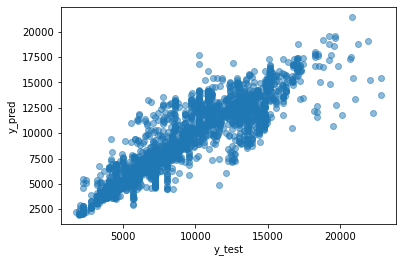

In [76]:
plt.scatter(y_test, y_pred, alpha = 0.5)
plt.xlabel("y_test")
plt.ylabel("y_pred")
plt.show()

### MSE

In [77]:
mean_squared_error(y_test,y_pred)

3021443.9136840254

### RMSE

In [78]:
np.sqrt(mean_squared_error(y_test,y_pred))

1738.230109532114

### r2 score

In [79]:
r2_score(y_test,y_pred)

0.8188631369737903

In [42]:
# Random Forest Regression accuracy score 82%

## AdaBoost Regressor Model

In [80]:
ada = AdaBoostRegressor()
ada.fit(x_train,y_train)

AdaBoostRegressor()

In [81]:
# adjusted r2 score
ada.score(x_train,y_train)

0.5904879253643305

In [82]:
ada.score(x_test,y_test)

0.5877540867935244

In [83]:
y_pred = ada.predict(x_test)
y_pred

array([ 6457.35195531, 10913.43361621, 10684.90037275, ...,
       10600.44802867, 11983.86852368,  6469.84378014])

### Scatter plot of AdaBoost Regressor Model

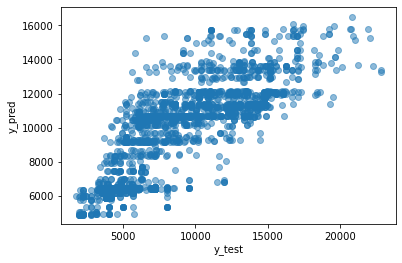

In [84]:
plt.scatter(y_test, y_pred, alpha = 0.5)
plt.xlabel("y_test")
plt.ylabel("y_pred")
plt.show()

### MSE

In [85]:
mean_squared_error(y_test,y_pred)

6876446.266040224

### RMSE

In [86]:
np.sqrt(mean_squared_error(y_test,y_pred))

2622.2978980352755

### r2 score

In [87]:
r2_score(y_test,y_pred)

0.5877540867935244

In [43]:
# AdaBoost Regression accuracy score 58%

### Hyperparameter Tuning in Random Forest Regressor Model

#### Using RandomizedSearchCV method for improving the r2 score

In [88]:
#Randomized Search CV

# Number of trees in random forest
n_estimators = [int(x) for x in np.linspace(start = 100, stop = 1200, num = 12)]
# Number of features to consider at every split
max_features = ['auto', 'sqrt']
# Maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(5, 30, num = 6)]
# Minimum number of samples required to split a node
min_samples_split = [2, 5, 10, 15, 100]
# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 2, 5, 10]

In [89]:
# Create the random grid

random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf}

In [90]:
# Random search of parameters, using 5 fold cross validation, 
# search across 100 different combinations
rf_random = RandomizedSearchCV(estimator = rf, param_distributions = random_grid,scoring='neg_mean_squared_error', n_iter = 10, cv = 5, verbose=2, random_state=42, n_jobs = 1)

In [91]:
rf_random.fit(x_train,y_train)

Fitting 5 folds for each of 10 candidates, totalling 50 fits
[CV] END max_depth=10, max_features=sqrt, min_samples_leaf=5, min_samples_split=5, n_estimators=900; total time=   5.4s
[CV] END max_depth=10, max_features=sqrt, min_samples_leaf=5, min_samples_split=5, n_estimators=900; total time=   5.5s
[CV] END max_depth=10, max_features=sqrt, min_samples_leaf=5, min_samples_split=5, n_estimators=900; total time=   5.2s
[CV] END max_depth=10, max_features=sqrt, min_samples_leaf=5, min_samples_split=5, n_estimators=900; total time=   5.3s
[CV] END max_depth=10, max_features=sqrt, min_samples_leaf=5, min_samples_split=5, n_estimators=900; total time=   5.3s
[CV] END max_depth=15, max_features=sqrt, min_samples_leaf=2, min_samples_split=10, n_estimators=1100; total time=   7.7s
[CV] END max_depth=15, max_features=sqrt, min_samples_leaf=2, min_samples_split=10, n_estimators=1100; total time=   9.0s
[CV] END max_depth=15, max_features=sqrt, min_samples_leaf=2, min_samples_split=10, n_estimator

RandomizedSearchCV(cv=5, estimator=RandomForestRegressor(), n_jobs=1,
                   param_distributions={'max_depth': [5, 10, 15, 20, 25, 30],
                                        'max_features': ['auto', 'sqrt'],
                                        'min_samples_leaf': [1, 2, 5, 10],
                                        'min_samples_split': [2, 5, 10, 15,
                                                              100],
                                        'n_estimators': [100, 200, 300, 400,
                                                         500, 600, 700, 800,
                                                         900, 1000, 1100,
                                                         1200]},
                   random_state=42, scoring='neg_mean_squared_error',
                   verbose=2)

In [92]:
rf_random.best_params_

{'n_estimators': 700,
 'min_samples_split': 15,
 'min_samples_leaf': 1,
 'max_features': 'auto',
 'max_depth': 20}

In [93]:
prediction = rf_random.predict(x_test)

### Scatter Plot

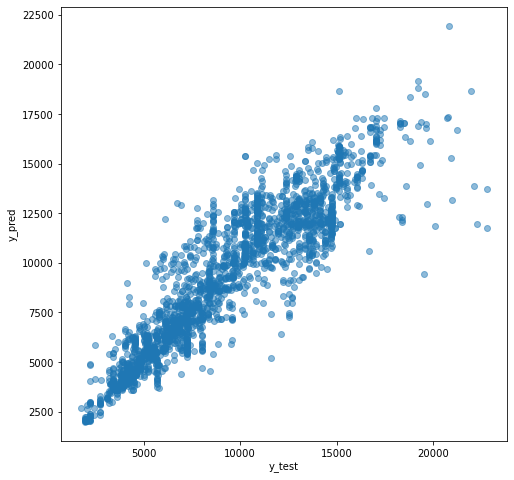

In [94]:
plt.figure(figsize = (8,8))
plt.scatter(y_test, prediction, alpha = 0.5)
plt.xlabel("y_test")
plt.ylabel("y_pred")
plt.show()

### MSE

In [95]:
mean_squared_error(y_test,y_pred)

6876446.266040224

### RMSE

In [96]:
np.sqrt(mean_squared_error(y_test,y_pred))

2622.2978980352755

### r2 score

In [97]:
r2_score(y_test,y_pred)

0.5877540867935244

In [ ]:
# I have tried to improve the accuracy score by using hyper parameter tunning in random forest algorithm.
# Hyper parameter is reducing the accuracy score.

## Regularization

In [98]:
# lasso regularization

lasscv = LassoCV(alphas = None,cv=10,max_iter=5000,normalize=True)

In [99]:
lasscv.fit(x_train,y_train)

LassoCV(cv=10, max_iter=5000, normalize=True)

In [100]:
# best alphas parameters

alpha = lasscv.alpha_
alpha

0.043574195912922165

In [101]:
# now we have best parameter lets use the lasso regularization

lasso_reg = Lasso(alpha)
lasso_reg.fit(x_train,y_train)

Lasso(alpha=0.043574195912922165)

In [102]:
lasso_reg.score(x_test,y_test)

0.5353502868294515

In [44]:
# I have used lasso for increasing accuracy score for linear regression but it is neither improving nor reducing the score.

### Saving the Best Model

In [103]:
import pickle

In [104]:
# saving the Random Forest Regressor Model

filename = 'finalized_model.pickle'
pickle.dump(rf,open(filename,'wb'))

loaded_model = pickle.load(open(filename,'rb'))

In [46]:
from IPython.display import Image
Image(url= "https://dataaspirant.com/wp-content/uploads/2017/04/Random-Forest-Introduction.jpg")

In [48]:
# The best model is Random Forest classifier whose accuracy score is 82%.